# Clustering

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kneed as kn
import plotly.graph_objects as go
import random

In [73]:
from plotly.subplots import make_subplots

#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr

# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from kneed import KneeLocator

In [74]:
from sklearn.metrics import *
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

In [75]:
df = pd.read_csv('train_cleaned_v.1.csv')

In [76]:
df.head()

,originalTitle,rating,startYear,runtimeMinutes,numVotes,totalImages,totalVideos,totalCredits,titleType,canHaveEpisodes,isRatable,isAdult,numRegions,ratingCount,countryOfOrigin,genres,ratingMean,ReviewsTotal,nominations
0,Neogenic Nightmare Chapter 3: Hydro-Man,"(7, 8]",1995,40,779,1,0,21,tvEpisode,False,True,False,1,781,['US'],"Action,Adventure,Animation",7.5,1,0
1,Looping,"(5, 6]",1982,28,11,1,0,1,videoGame,False,True,False,1,11,['XWG'],Action,5.5,0,0
2,Idealnaya para,"(5, 6]",1992,92,38,1,0,24,movie,False,True,False,1,38,['RU'],Comedy,5.5,1,0
3,MasterChef Celebrity México,"(5, 6]",2021,53,15,22,0,56,tvSeries,True,True,False,1,15,['MX'],Reality-TV,5.5,0,0
4,Seutateueob,"(7, 8]",2020,80,15718,347,2,47,tvSeries,True,True,False,32,15746,['KR'],"Comedy,Drama,Romance",7.5,456,2


#### Fill missing values and convert to numerical (where possible)

In [77]:
df.dtypes

originalTitle       object
rating              object
startYear            int64
runtimeMinutes       int64
numVotes             int64
totalImages          int64
totalVideos          int64
totalCredits         int64
titleType           object
canHaveEpisodes       bool
isRatable             bool
isAdult               bool
numRegions           int64
ratingCount          int64
countryOfOrigin     object
genres              object
ratingMean         float64
ReviewsTotal         int64
nominations          int64
dtype: object

In [78]:
del df['originalTitle']
del df['rating']
del df['titleType']
del df['countryOfOrigin']
del df['genres']
del df['isAdult']
del df['isRatable']
del df['canHaveEpisodes']
del df['runtimeMinutes']
del df['numVotes']
del df['totalVideos']
del df['totalCredits']
del df['nominations']
del df['totalImages']



In [79]:

#del df['awardWins'] #HA DEI VALORI MANCANTI, VEDIAMO COSA FARNE

In [80]:
df.head()

,startYear,numRegions,ratingCount,ratingMean,ReviewsTotal
0,1995,1,781,7.5,1
1,1982,1,11,5.5,0
2,1992,1,38,5.5,1
3,2021,1,15,5.5,0
4,2020,32,15746,7.5,456


In [ ]:
#NORMALIZZAZIONE MINMAX O ZSCORE, COMMMENTARE UNA DELLE DUE RIGHE IN BASE AL TIPO DI NORMALIZZAZIONE CHE SI VUOLE UTILIZZARE
#PER I NOSTRI DATI è MEGLIO MIN/MAX, Z-SCORE FA CAGARE PERCHÉ I DATI NON SONO DISTRIBUITI NORMALMENTE (SCRIVERLO NEL REPORT)

scaler = MinMaxScaler()
#scaler = StandardScaler()
train_data = scaler.fit_transform(df)
df.to_csv('train_data.csv', sep=';', index=False, header=True)

In [82]:
%%time
sse_list = []
sil_list = []
k_values = range(2, 21)

for k in k_values:
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(train_data)
    sse_list.append(kmeans.inertia_)
    sil_list.append(silhouette_score(train_data, kmeans.labels_))

kn = KneeLocator(k_values, sse_list, curve='convex', direction='decreasing')
elbow_k = kn.elbow
print("Numero ottimale di cluster (k) secondo il metodo del gomito:", elbow_k)

c:\Users\tomma\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\tomma\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Numero ottimale di cluster (k) secondo il metodo del gomito: 7
CPU times: total: 1min 44s
Wall time: 1min 11s


276.25845693195294


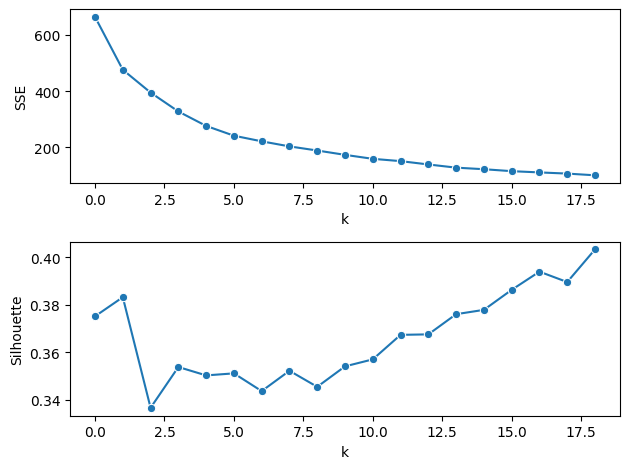

In [83]:

fig, axs = plt.subplots(2) # 1 row, 2 columns

sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o', ax=axs[0])
axs[0].set(xlabel='k', ylabel='SSE')
sns.lineplot(x=range(len(sil_list)), y=sil_list, marker='o', ax=axs[1])
axs[1].set(xlabel='k', ylabel='Silhouette')

plt.tight_layout() # Adjust the padding between and around subplots

print(sse_list[4]) #PUNTO IN CUI MI SEMBRA CI SIA IL GOMITO CHE CORRISPONDE A K = 6

In [84]:


# Crea la figura con due sottotrame (subplots)
fig = make_subplots(rows=1, cols=2, subplot_titles=("SSE vs k", "Silhouette Score vs k"))

# Grafico SSE vs k
fig.add_trace(
    go.Scatter(x=list(range(len(sse_list))), y=sse_list, mode='lines+markers', name="SSE"),
    row=1, col=1
)
fig.update_xaxes(title_text="k", row=1, col=1)
fig.update_yaxes(title_text="SSE", row=1, col=1)

# Grafico Silhouette Score vs k
fig.add_trace(
    go.Scatter(x=list(range(len(sil_list))), y=sil_list, mode='lines+markers', name="Silhouette"),
    row=1, col=2
)
fig.update_xaxes(title_text="k", row=1, col=2)
fig.update_yaxes(title_text="Silhouette Score", row=1, col=2)

# Layout generale della figura
fig.update_layout(title_text="SSE e Silhouette Score per il clustering K-Means",
                  showlegend=False)

# Mostra il grafico
fig.show()

# Mostra il valore dell'SSE per k=6
print(sse_list[4]) # Corrisponde a k = 6, dato che la lista parte da 0


276.25845693195294


In [85]:
kmeans = KMeans(init='k-means++', n_clusters=6, n_init=10, max_iter=100)
kmeans.fit(train_data)

KMeans(max_iter=100, n_clusters=6, n_init=10)

In [86]:
print('centroids', kmeans.cluster_centers_)
print('labels', np.unique(kmeans.labels_, return_counts=True))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(train_data, kmeans.labels_))

centroids [[8.96946059e-01 1.39646889e-02 4.15439238e-04 8.29961828e-01
  1.29229755e-03]
 [8.33167494e-01 4.06226666e-02 2.93342218e-04 3.78780755e-01
  3.70926270e-03]
 [8.87947266e-01 2.84888333e-02 2.48897081e-04 6.23443983e-01
  1.83543403e-03]
 [3.95556981e-01 5.35076828e-02 2.10513019e-04 5.88024040e-01
  2.82619609e-03]
 [7.73459597e-01 4.18462729e-01 4.10386518e-02 6.70715250e-01
  8.51232489e-02]
 [6.64528253e-01 2.28490657e-02 1.64845473e-04 7.20417804e-01
  1.28630550e-03]]
labels (array([0, 1, 2, 3, 4, 5], dtype=int32), array([4861, 1418, 3871, 1518,  494, 3770]))
sse 276.28779785482067
silhouette 0.3500258865253186


In [87]:
n_points = train_data.shape[0]
#generate distance matrix
distance_matrix = squareform(pdist(train_data, metric='euclidean')) 

#Otteniamo le etichette di cluster dal modello k-means
labels = kmeans.labels_

#generate ideal similarity matrix
similarity_matrix = np.equal.outer(labels, labels).astype(int)


# Convertiamo la matrice delle distanze in una matrice di similarità
# (simply similarity_matrix = max_distance - distance_matrix)
max_distance = np.max(distance_matrix)
similarity_from_distance = distance_matrix - max_distance 

'''
# Rendi entrambe le matrici 1D per il calcolo della correlazione
similarity_from_distance_flat = similarity_from_distance.flatten()
similarity_matrix_flat = similarity_matrix.flatten()

# Calcola la correlazione di Pearson
correlation, _ = pearsonr(similarity_from_distance_flat, similarity_matrix_flat)

print("Correlation between distance and ideal similarity matrices:", correlation)
'''
# Selezioniamo solo la parte inferiore della matrice, inclusa la diagonale
lower_triangle_indices = np.tril_indices(n_points)

# Appiattiamo solo la parte inferiore della matrice
similarity_from_distance_flat = similarity_from_distance[lower_triangle_indices]
similarity_matrix_flat = similarity_matrix[lower_triangle_indices]

# Calcolare la correlazione di Pearson tra i vettori appiattiti
correlation, _ = pearsonr(similarity_from_distance_flat, similarity_matrix_flat)

print("Correlation between distance and ideal similarity matrices:", correlation)

Correlation between distance and ideal similarity matrices: -0.5084669956597625


In [88]:
import plotly.graph_objects as go

train_data = pd.DataFrame(train_data)

# Crea una figura vuota
fig = go.Figure()

# Aggiungi una linea per ogni centroide del cluster
for i, center in enumerate(kmeans.cluster_centers_):
    fig.add_trace(go.Scatter(
        x=list(df.columns),
        y=center,
        mode='lines+markers',
        name=f'Cluster {i}',
        line=dict(width=3)
    ))

# Imposta il titolo e le etichette
fig.update_layout(
    title="Centroid values for each feature across clusters",
    xaxis_title="Features",
    yaxis_title="Centroid values",
    legend=dict(x=1, y=1),
    width=800, height=400
)

# Aggiungi la griglia all'asse y
fig.update_yaxes(showgrid=True)

# Mostra il grafico
fig.show()


PROVA CONFRONTO DATI RANDOMIZZATI

In [89]:
def randomize_data(train_data):
    """Randomizza l'ordine delle righe del dataset"""
    return np.random.permutation(train_data)

# Calcola il clustering per i dati randomizzati
def kmeans_on_random_data(train_data, k):
    X_randomized = randomize_data(train_data)
    kmeans_random = KMeans(n_clusters=k, random_state=42)
    kmeans_random.fit(X_randomized)
    sse_random = kmeans_random.inertia_
    silhouette_random = silhouette_score(X_randomized, kmeans_random.labels_)
    return sse_random, silhouette_random

In [90]:
n_permutations = 100  # Numero di permutazioni per SSE
sse_random_results = []
silhouette_random_results = []

for _ in range(n_permutations):
    sse_random, silhouette_random = kmeans_on_random_data(train_data, k)
    sse_random_results.append(sse_random)
    silhouette_random_results.append(silhouette_random)

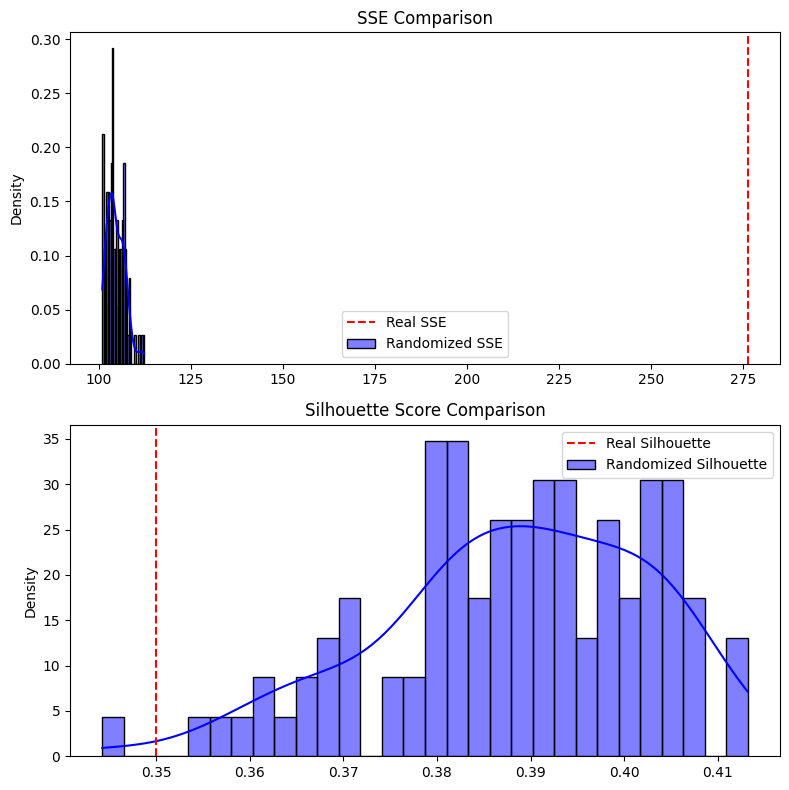

In [91]:
sse_real = kmeans.inertia_
silhouette_real = silhouette_score(train_data, kmeans.labels_)
# Visualizza i risultati di SSE per i dati reali e randomizzati
plt.figure(figsize=(8, 8))

# Plotta gli histogrammi per SSE
plt.subplot(2, 1, 1)
sns.histplot(sse_random_results, kde=True, label='Randomized SSE', color='blue', stat='density', bins=30)
plt.axvline(x=sse_real, color='red', linestyle='--', label='Real SSE')
plt.legend()
plt.title('SSE Comparison')

# Plotta gli histogrammi per Silhouette
plt.subplot(2, 1, 2)
sns.histplot(silhouette_random_results, kde=True, label='Randomized Silhouette', color='blue', stat='density', bins=30)
plt.axvline(x=silhouette_real, color='red', linestyle='--', label='Real Silhouette')
plt.legend()
plt.title('Silhouette Score Comparison')

plt.tight_layout()
plt.show()

### Analysis by centroid-based methods

- K-Means (mandatory), Bisecting K-Means (optional), X-Means (optional);

- Choice the attributes, identify the best value of k, discuss the clusters.

### Analysis by density-based clustering

- DBSCAN (mandatory), OPTICS (optional);

- Choice the attributes, identify the best parameter configuration, discuss clusters.

### Analysis by hierarchical clustering

- Choice the attributes, the distance function, analyse several dendrograms.

### Final discussion

- Which is the best algorithm? Remember that best is studied w.r.t. several aggregate 
statistics, cluster distributions and w.r.t. the typology of algorithm used for that 
particular dataset;
